In [12]:
# Code used to create the results in section 4.8.1 of the paper 
# "Analysis and Comparison of Classification Metrics" 

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import expit, logit, logsumexp 
from expected_cost import ec, utils
from expected_cost.data import create_scores_for_expts
import re


def plot_vertical_line(x, ylim, style):
    plt.plot([x,x], ylim, style)

def value_at_thr(values, thrs, sel_thr):
    # Find the value in thrs that is closest to sel_thr
    # and then return the value in values for that thr.
    i = np.argmin(np.abs(np.array(thrs)-sel_thr))
    return values[i]


**** Creating simulated data with Gaussian class distributions for 2 classes ****



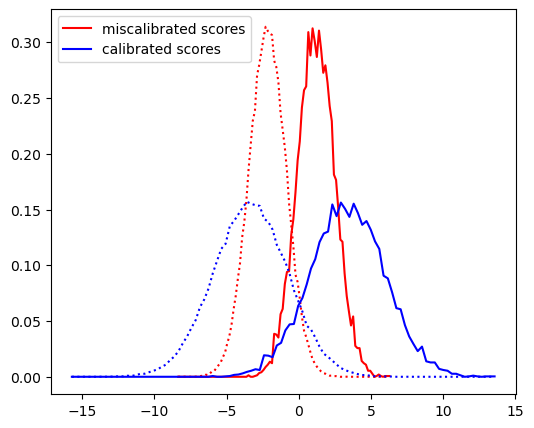

In [13]:
# Get the simulated likelihoods and then convert them to LLRs, because it makes them
# nicer for plotting and for interpretation of the scores.

num_targets = 2
score_dict, targets = create_scores_for_expts(num_targets, calibrate=False, score_scale_mc2=0.2)
mis_llks = score_dict['mc1']['llks']
cal_llks = score_dict['cal']['llks']
mis_llrs = mis_llks[:,1] - mis_llks[:,0]
cal_llrs = cal_llks[:,1] - cal_llks[:,0]

# Number of samples from each class
N0 = sum(targets==0)
N1 = sum(targets==1)
K = N0 + N1

# Plot the resulting distributions
plt.figure(figsize=(6,5))
c, hs = utils.make_hist(targets, mis_llrs)
plt.plot(c, hs[1], 'r-', label='miscalibrated scores')
plt.plot(c, hs[0], 'r:')

c, hs = utils.make_hist(targets, cal_llrs)
plt.plot(c, hs[1], 'b-', label='calibrated scores')
plt.plot(c, hs[0], 'b:')
plt.legend()

outdir = "outputs/Metrics_over_scores"
utils.mkdir_p(outdir)
plt.savefig("%s/score_dists.pdf"%outdir)


In [14]:
# Now, we take miscalibrated and calibrated llrs and choose a bunch 
# of different decision thresholds and compute a few metrics
# for each case.
score_dict = {'miscal_scores': mis_llrs, 'cal_scores': cal_llrs}

# We consider two priors, the ones in the data and the uniform one
priors_data = np.array([N0/K, N1/K])
priors_unif = np.array([0.5, 0.5])

# We consider to cost matrices, the usual 0-1 matrix
# and one with a higher weight for K10
costs_01 = ec.CostMatrix([[0, 1], [1, 0]])
costs_0b = ec.CostMatrix([[0, 1], [2, 0]])

colors = {'EC1': 'b', 'EC2': 'r', 'EC3': 'g', 'FS': 'k'} #, 'MCC': 'k'}
metrics = colors.keys()

*** Metric values at different thresholds for miscal_scores
    Threshold_type       (   Thr  )    EC1    EC2    EC3    FS     
    bayes_thr_for_EC1    (  0.000 )   0.222  0.590  0.383  0.736  
    bayes_thr_for_EC2    (  2.197 )   0.784  0.787  0.785  0.355  
    bayes_thr_for_EC3    (  1.504 )   0.596  0.615  0.604  0.569  
    best_thr_for_EC1     ( -0.470 )   0.190  0.931  0.515  0.660  
    best_thr_for_EC2     (  0.640 )   0.348  0.464  0.399  0.742  
    best_thr_for_EC3     (  0.220 )   0.256  0.507  0.366  0.754  
    best_thr_for_FS      (  0.330 )   0.276  0.484  0.367  0.756  

*** Metric values at different thresholds for cal_scores
    Threshold_type       (   Thr  )    EC1    EC2    EC3    FS     
    bayes_thr_for_EC1    (  0.000 )   0.191  0.964  0.529  0.653  
    bayes_thr_for_EC2    (  2.197 )   0.339  0.467  0.395  0.744  
    bayes_thr_for_EC3    (  1.504 )   0.263  0.501  0.367  0.754  
    best_thr_for_EC1     (  0.060 )   0.190  0.931  0.515  0.660  
    best_

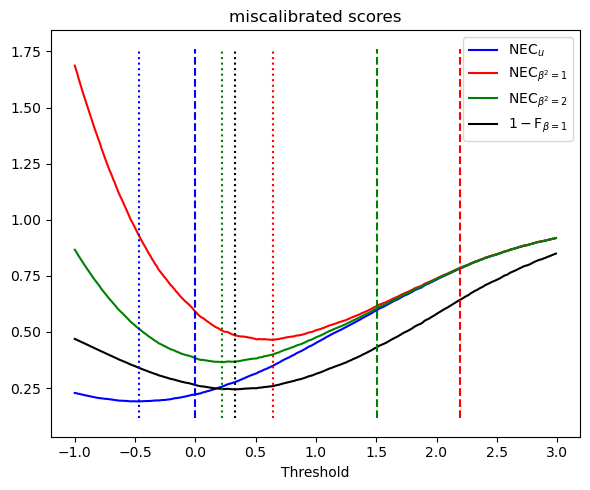

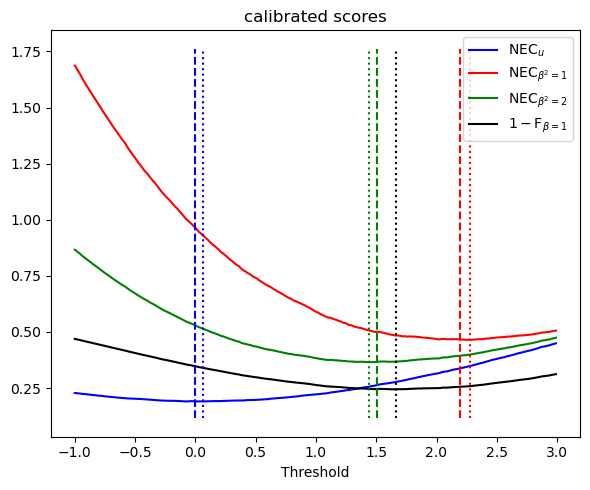

In [15]:
for score_name, scores in score_dict.items():

    print("*** Metric values at different thresholds for %s"%score_name)

    # The dict below will accumulate a list of values for each threshold, for each metric
    metric_dict = dict([(m, []) for m in metrics])

    thrs = np.arange(-1,3,0.01)

    for thr in thrs:

        # Number of samples of class 0 with a score larger than the thr (ie, labelled as class 1)
        K01 = np.sum(scores[targets==0]>thr)
        # Number of samples of class 1 with a score smaller than the thr (ie, labelled as class 0)
        K10 = np.sum(scores[targets==1]<thr)

        # Get the normalized confusion matrix needed to compute the metrics
        R = utils.compute_R_matrix_from_counts_for_binary_classif(K01, K10, N0, N1)

        # Compute various metrics based on the confusion matrix
        metric_dict['EC1'].append(ec.average_cost_from_confusion_matrix(R, priors_unif, costs_01, adjusted=True))
        metric_dict['EC2'].append(ec.average_cost_from_confusion_matrix(R, priors_data, costs_01, adjusted=True))
        metric_dict['EC3'].append(ec.average_cost_from_confusion_matrix(R, priors_data, costs_0b, adjusted=True))
        metric_dict['FS'].append(utils.Fscore(K10, K01, N0, N1))
        

    for metric_name, metric_list in metric_dict.items():
        metric_dict[metric_name] = np.array(metric_list)

    plt.figure(figsize=(6,5))
    plt.plot(thrs, metric_dict['EC1'], label=r'$\mathrm{NEC}_u$', color=colors['EC1'])
    plt.plot(thrs, metric_dict['EC2'], label=r'$\mathrm{NEC}_{\beta^2=1}$', color=colors['EC2'])
    plt.plot(thrs, metric_dict['EC3'], label=r'$\mathrm{NEC}_{\beta^2=2}$', color=colors['EC3'])
    plt.plot(thrs, 1-metric_dict['FS'], label=r'$1-\mathrm{F}_{\beta=1}$', color=colors['FS'])

    # Compute the best and the Bayes (only for ECs) thresholds for each metric.
    thr_dict = dict()
    thr_dict['bayes_thr_for_EC1'] = utils.bayes_thr_for_llrs(priors_unif, costs_01)
    thr_dict['bayes_thr_for_EC2'] = utils.bayes_thr_for_llrs(priors_data, costs_01)
    thr_dict['bayes_thr_for_EC3'] = utils.bayes_thr_for_llrs(priors_data, costs_0b)
    thr_dict['best_thr_for_EC1']  = thrs[np.nanargmin(metric_dict['EC1'])]
    thr_dict['best_thr_for_EC2']  = thrs[np.nanargmin(metric_dict['EC2'])]
    thr_dict['best_thr_for_EC3']  = thrs[np.nanargmin(metric_dict['EC3'])]
    thr_dict['best_thr_for_FS']   = thrs[np.nanargmin(1-metric_dict['FS'])]

    # Plot the curves
    ylim = plt.ylim()
    for metric in metrics:
        plot_vertical_line(thr_dict['best_thr_for_'+metric], ylim, colors[metric]+':')
        if 'EC' in metric:
            plot_vertical_line(thr_dict['bayes_thr_for_'+metric], ylim, colors[metric]+'--') 
    plt.xlabel("Threshold")
    plt.legend(loc='upper right')
    plt.title(re.sub("cal", "calibrated", re.sub("_"," ",score_name)))
    plt.tight_layout()
    plt.savefig("%s/%s.pdf"%(outdir, score_name))

    # Now, print the value of every metric for every threshold above
    print("    Threshold_type       (   Thr  )    ", end='')
    for metric in metrics:
        print(f"{metric:5s}  ", end='')
    print("")

    for thr_name, thr in thr_dict.items():
        print(f"    {thr_name:<20s} ( {thr:6.3f} )   ", end='')
        for metric in metrics:
            m = value_at_thr(metric_dict[metric], thrs, thr)
            print(f"{m:5.3f}  ", end='')
        print("")
    print("")

In the table above we can see that:

* The metrics are immune to calibration issues when computed for decisions made with thresholds optimized for that specific metric (e.g., the value of EC1 is the same on calibrated or miscalibrated scores for the "best_thr_for_EC1" decisions).
* With F-score we have no direct way to tell if we have a calibration problem.
* With EC, we can compare the metric for the bayes and the best threshold. If the first is worse than the latter, then we know we have a calibration problem.
* The thresholds selected for EC1 are highly suboptimal for EC2, and conversely.
* For this particular data, the decisions would be the same if we optimize the threshold for EC2 or F-score.

You can play with the priors, costs, or score distribution parameters to see how the metrics change.